In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

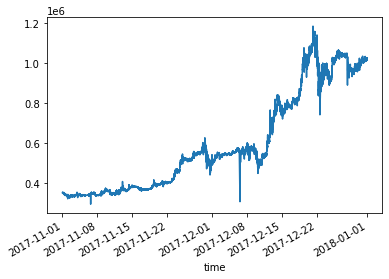

In [2]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

In [3]:
# Q. 코드를 작성해주세요

# window 지정
window = 10 # 앞서 사용한 window의 값은 10입니다.

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1) # modify_data['close'].shift(window)활용

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index) # 데이터 활용을 위해 pd.Series를 사용합니다.

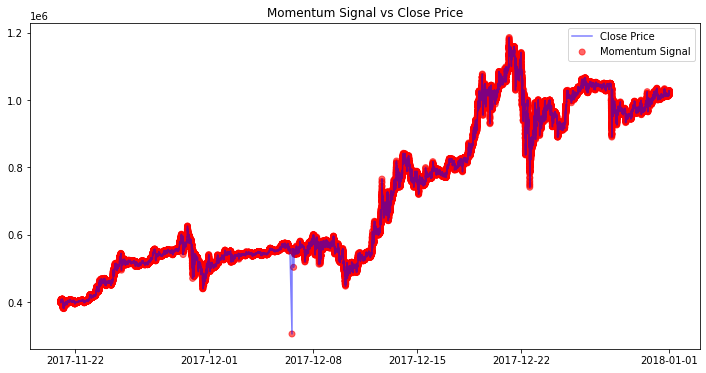

In [4]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21':'2017-12-31', 'close'] # loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig = pd.DataFrame({'momentum_signal': s_momentum_signal.loc['2017-11-21':'2017-12-31'], 
                      'close': sub_data}) # loc를 활용하여 2017-11-21의 시간대별 값을 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig['momentum_signal'] > 1, 'green', 'red')

# 시각화하기
plt.figure(figsize=(12, 6))
plt.scatter(c_sig.index, c_sig['close'], c=c_sig['color'], alpha=0.6, label='Momentum Signal')
plt.plot(sub_data, color='blue', alpha=0.5, label='Close Price')
plt.title('Momentum Signal vs Close Price')
plt.legend()
plt.show()

In [5]:
# Q. 코드를 작성해주세요

# momentum_signal 생성
momentum_signal = np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1  # rolling(window).mean() 활용

# s_momentum_signal 생성
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)  # pd.Series로 변환


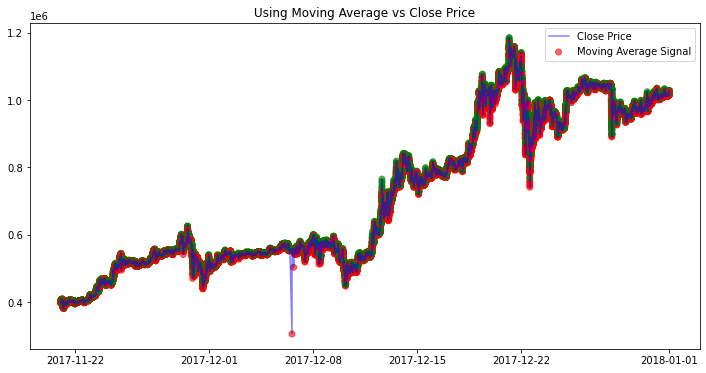

In [6]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21':'2017-12-31', 'close']  # loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
ma_signal = s_momentum_signal.loc['2017-11-21':'2017-12-31']  # momentum_signal 값 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기
comparison_df = pd.DataFrame({'momentum_signal': ma_signal, 'close': sub_data})
comparison_df['color'] = np.where(comparison_df['momentum_signal'] > 1, 'green', 'red')  # np.where 사용

# 시각화하기
plt.figure(figsize=(12, 6))
plt.scatter(comparison_df.index, comparison_df['close'], c=comparison_df['color'], alpha=0.6, label='Moving Average Signal')
plt.plot(sub_data, color='blue', alpha=0.5, label='Close Price')
plt.title('Using Moving Average vs Close Price')
plt.legend()
plt.show()

In [7]:
# Q. 코드를 작성해주세요

# Local min / max를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0

    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False

    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True

        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                min_value = val
                n_cnt_min = 0

        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                max_value = val
                n_cnt_max = 0

    return mins, maxes


In [8]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# # mins, maxes 출력 확인
# print(mins)
# print('--' * 20)
# print(maxes)

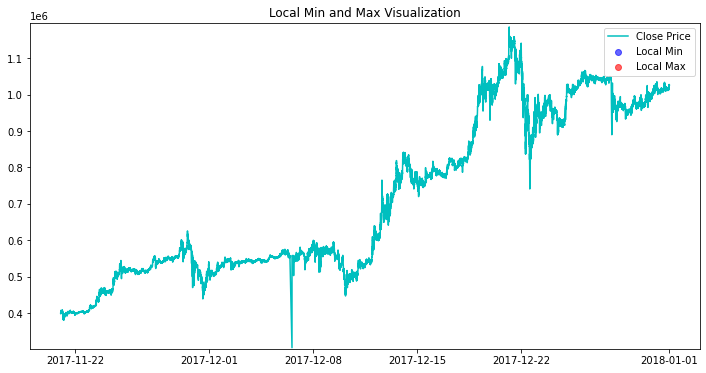

In [9]:
# subplots 및 plot 생성
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(sub_data, 'c', label='Close Price')

# min_time, local_min을 활용한 scatter plot 생성
valid_mins = [idx for idx in mins if idx < len(sub_data)]
valid_maxes = [idx for idx in maxes if idx < len(sub_data)]

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(sub_data.index[valid_mins], sub_data.iloc[valid_mins], color='blue', label='Local Min', alpha=0.6)
ax.scatter(sub_data.index[valid_maxes], sub_data.iloc[valid_maxes], color='red', label='Local Max', alpha=0.6)

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max() * 1.01])

# 제목과 범례 추가
ax.set_title('Local Min and Max Visualization')
ax.legend()

plt.show()


In [10]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [11]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [12]:
# Q. 코드를 작성해주세요

# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [20:56<00:00, 26.57it/s]


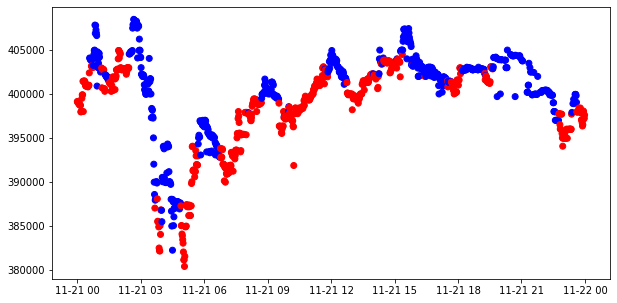

In [13]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

In [14]:
 !pip install ta==0.9.0
 !pip install shap

In [15]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [16]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [17]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [18]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [19]:
# Q. 코드를 작성해주세요

df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1] # iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [20]:
# Q. 코드를 작성해주세요

# RandomForest 모델 적용
rfc = RandomForestClassifier(random_state=42)

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(random_state=42)

In [21]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.039110,0.001788
volume_fi,0.041509,0.002297
volume_mfi,0.049099,0.002929
volume_sma_em,0.034699,0.001726
volume_vpt,0.024173,0.001320
volatility_atr,0.075890,0.003291
volatility_ui,0.048859,0.002219
trend_macd_diff,0.084576,0.004312
trend_adx,0.052292,0.002201
trend_trix,0.065693,0.002647


In [22]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [23]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

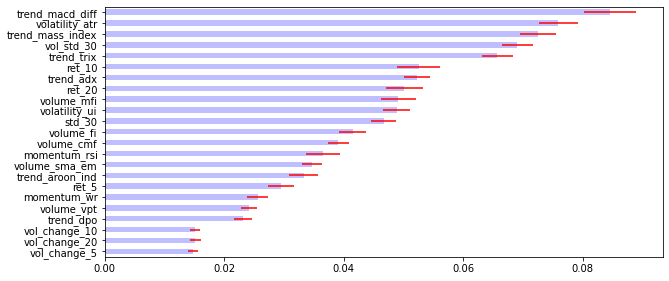

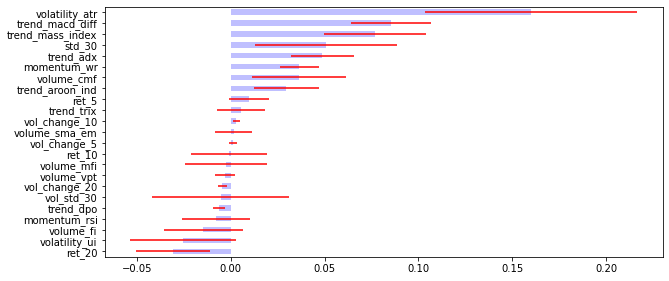

In [24]:
# Q. 코드를 작성해주세요

# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)


In [25]:
# Q. 코드를 작성해주세요

# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(estimator=svc_rbf, step=1, cv=5, scoring='accuracy') # RFECV
rfe_fitted = rfe_cv.fit(X_sc, y) # fit

In [26]:
# 선택된 피쳐 확인하기

print(X.columns[rfe_fitted.support_])

Index(['volume_fi', 'volatility_atr', 'trend_macd_diff', 'trend_aroon_ind',
       'momentum_rsi', 'momentum_wr', 'ret_20', 'std_30'],
      dtype='object')


In [27]:
# SFS, Sequential Feature Selection

n = 8
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [28]:
# 선택된 피쳐 확인하기
selected_features = X.columns[sfs_fitted.support_]
print("Selected features:", selected_features)

Selected features: Index(['volume_fi', 'volume_mfi', 'trend_macd_diff', 'trend_adx', 'trend_dpo',
       'ret_5', 'vol_change_10', 'vol_change_20'],
      dtype='object')


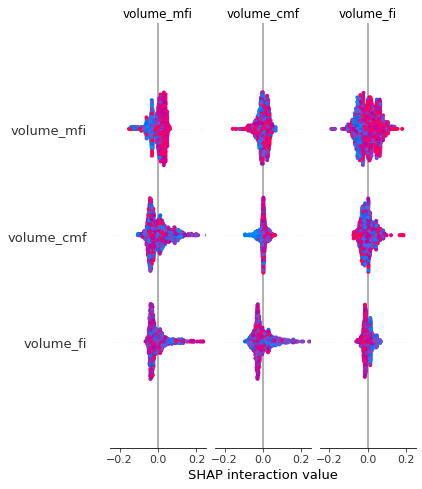

In [29]:
# Q. 코드를 작성해주세요

# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_values, X_sc)

In [30]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [31]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_data = pd.read_pickle(data_file_name)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

In [32]:
# Purged K-Fold 설정
n_cv = 4  # 4개의 폴드로 나눔

t1 = pd.Series(train_y.index.values, index=train_y.index)  # 시간 인덱스 설정
cv = PKFold(n_splits=n_cv, samples_info_sets=t1, pct_embargo=0.01)

In [33]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

In [34]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [35]:
bag_rfc = BaggingClassifier(base_estimator=rfc, n_estimators=10, random_state=42)

In [36]:
gs_rfc = GridSearchCV(
    estimator=bag_rfc,
    param_grid=bc_params,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)

In [37]:
# fit
gs_rfc.fit(train_x, train_y)

# best estimator 
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        max_features=None,
                                                        min_samples_leaf=10),
                  bootstrap_features=True, max_features=0.7, random_state=42)

In [38]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [39]:
# Confusion Matrix 및 평가 지표 계산
confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y, average='macro')  # 'macro', 'micro', or 'weighted'
recall = recall_score(test_y, pred_y, average='macro')

# 결과 출력
print("================ Confusion Matrix ================")
print(confusion)
print(f"정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall}")

================ Confusion Matrix ================
[[38 18 23]
 [13 15 29]
 [ 0 13 42]]
정확도: 0.4973821989528796, 정밀도: 0.5059978354585745, 재현율: 0.5026023055336847


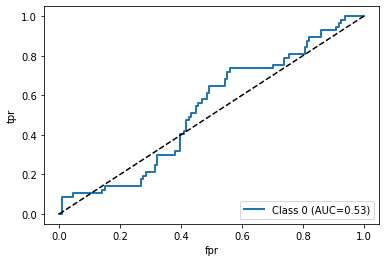

auc:0.5285415030112595


In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# 클래스 확인
if len(set(test_y)) > 1:  # 두 개 이상의 클래스가 있는지 확인
    # test_y를 원-핫 인코딩
    n_classes = len(set(test_y))
    y_bin = label_binarize(test_y, classes=list(range(n_classes)))

    # ROC curve 및 AUC 계산 (첫 번째 클래스 예시)
    fpr, tpr, thresholds = roc_curve(y_bin[:, 0], prob_y[:, 0])
    auc = roc_auc_score(y_bin[:, 0], prob_y[:, 0])

    # ROC curve 시각화
    plt.plot(fpr, tpr, linewidth=2, label=f"Class 0 (AUC={auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')  # 대각선 기준선
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend(loc="lower right")
    plt.show()

    # AUC 출력
    print(f'auc:{auc}')
else:
    print("Warning: Only one class present in test_y. ROC AUC score cannot be calculated.")
